In [1]:
import os
import numpy as np
from dataset import ClusterEvalDataset, ClusterTestDataset
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import torch
from model import MyModel
from torch.utils.data import DataLoader
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
import torch

In [430]:
normal_idx = np.flatnonzero(np_label == 2)
incorrect_idx = np.flatnonzero(np_label == 1)

In [4]:
device='cuda'
model = MyModel('efficientnet-b0').to(device)
model.load_state_dict(torch.load('/opt/ml/code/save/cluster/log9_3.pt'))
model.eval()
print('model ready')

Loaded pretrained weights for efficientnet-b0
model ready


In [431]:
df_test_normal = df_test.iloc[normal_idx]
df_test_incorrect = df_test.iloc[incorrect_idx]

In [107]:
df_test = pd.read_csv('/opt/ml/input/data/eval/info.csv')
df_key = pd.read_csv('/opt/ml/code/df/df_key_cluster.csv')
df_valid = pd.read_csv('/opt/ml/code/df/df_valid_cluster.csv')

In [94]:
bins = [0, 29, 59, 100]
labels = [0, 1, 2]
df_key['age'] = pd.cut(df_key['age'], bins=bins, labels=labels)

In [96]:
df_valid

,id,gender,race,age,path,mask
0,0,0,Asian,1,/opt/ml/input/data/train/images/003561_male_As...,1
1,0,0,Asian,1,/opt/ml/input/data/train/images/003561_male_As...,0
2,0,0,Asian,1,/opt/ml/input/data/train/images/003561_male_As...,0
3,0,0,Asian,1,/opt/ml/input/data/train/images/003561_male_As...,0
4,0,0,Asian,1,/opt/ml/input/data/train/images/003561_male_As...,0
...,...,...,...,...,...,...
3775,539,0,Asian,0,/opt/ml/input/data/train/images/001727_male_As...,0
3776,539,0,Asian,0,/opt/ml/input/data/train/images/001727_male_As...,0
3777,539,0,Asian,0,/opt/ml/input/data/train/images/001727_male_As...,0
3778,539,0,Asian,0,/opt/ml/input/data/train/images/001727_male_As...,0


In [95]:
df_valid['age'] = pd.cut(df_valid['age'], bins=bins, labels=labels)

In [5]:
transform = transforms.Compose([
                transforms.CenterCrop(350),
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [432]:
normal_dataset = ClusterEvalDataset(df_test_normal, transform)
incorrect_dataset = ClusterEvalDataset(df_test_incorrect, transform)
dataloader_normal = DataLoader(normal_dataset, batch_size=64, shuffle=False, num_workers=2)
dataloader_incorrect = DataLoader(incorrect_dataset, batch_size=64, shuffle=False, num_workers=2)

In [164]:
mtx = model.create_mtx(dataloader, device)

100%|██████████| 29/29 [00:05<00:00,  5.10it/s]


In [172]:
mtx_ = mtx.copy()

In [173]:
ind = np.unravel_index(np.argsort(mtx_, axis=None), mtx_.shape)
print(ind)

(array([   0,  595,  596, ..., 1230, 1327,  186]), array([   0,  595,  596, ..., 1702,  186, 1327]))


In [345]:
ind_x, ind_y = ind
ind_x, ind_y = ind_x[::2], ind_y[::2]

In [354]:
i = 0

In [347]:
print(len(ind_x))

1623602


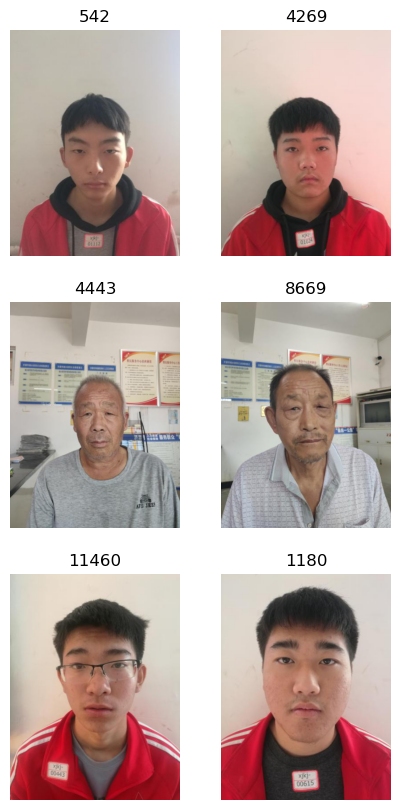

In [424]:
while ind_x[i] == ind_y[i]:
    i += 1

img_idx1 = normal_idx[ind_x[i]]
img_idx2 = normal_idx[ind_y[i]]

# while img_idx1 != 7958 and img_idx2 != 7958:
#     i += 1
#     img_idx1 = normal_idx[ind_x[i]]
#     img_idx2 = normal_idx[ind_y[i]]
# print(i)


fig, axes = plt.subplots(3, 2, figsize=(5, 10))

for rows in axes:
    img_idx1 = normal_idx[ind_x[i]]
    img_idx2 = normal_idx[ind_y[i]]
    for ax, img_idx in zip(rows, [img_idx1, img_idx2]):
        img = Image.open(os.path.join('/opt/ml/input/data/eval/images', df_test.iloc[img_idx]['ImageID']))
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'{img_idx}')
    i += 1
plt.show()

In [438]:
mtx_ = mtx.copy()

In [439]:
groups_idx = mtx_.argsort(axis=1)[:,:7]
mtx_.sort(axis=1)
groups_dst = mtx_[:,:7]
len(groups_dst)

1802

In [446]:
i = 0

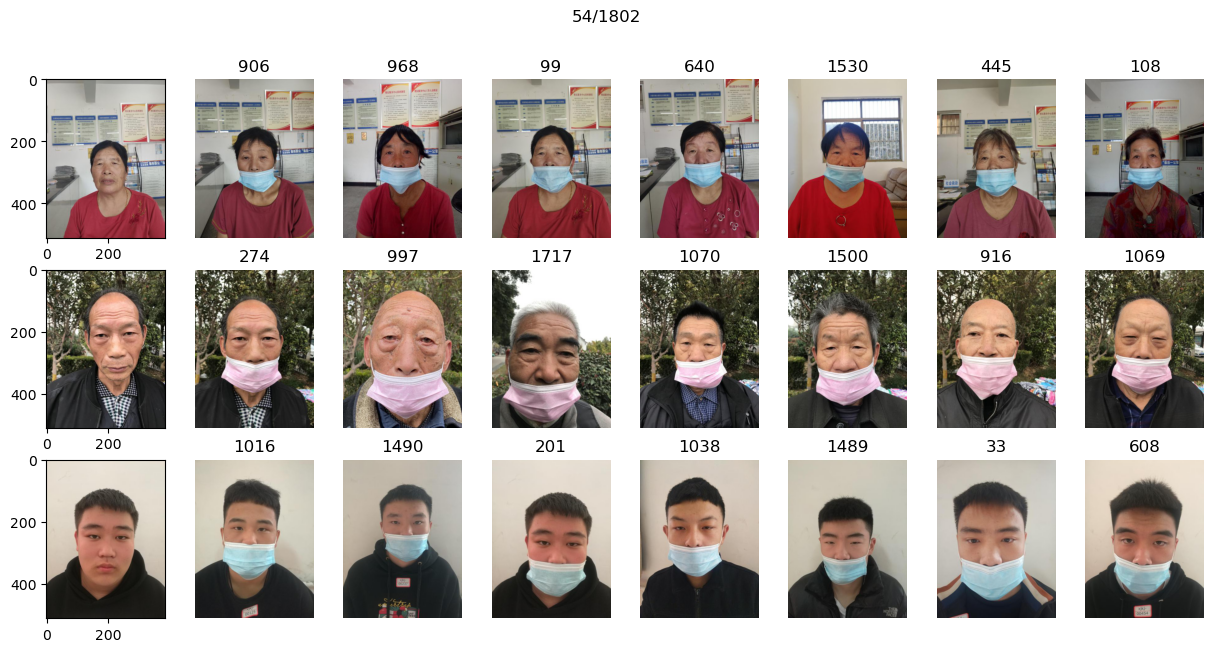

In [464]:
fig, axes = plt.subplots(3, 8, figsize=(15, 7))
fig.suptitle(f'{i+3}/{len(df_test_normal)}')
for row in axes:
    img = Image.open(os.path.join('/opt/ml/input/data/eval/images', df_test_normal.iloc[i]['ImageID']))
    row[0].imshow(img)
    for ax, idx, dst in zip(row[1:], groups_idx[i], groups_dst[i]):
        img = Image.open(os.path.join('/opt/ml/input/data/eval/images', df_test_incorrect.iloc[idx]['ImageID']))
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'{idx}')
    i += 1
plt.show()

1356, 1535

In [38]:
len(df_test) // 7

1800

In [ ]:
# fig, axes = plt.subplots(1, n + 1, figsize=(15, 5))
# axes[0].imshow(img_pil)
# axes[0].axis('off')
# axes[0].set_title('query')

# for ax, i in zip(axes[1:], groups_idx):
#     img = Image.open(df_key.iloc[i]['path'])
#     ax.imshow(img)
#     ax.axis('off')
#     ax.set_title(df_key.iloc[i]['gender'])

# plt.show()

In [428]:
from scipy.spatial import distance_matrix
from tqdm import tqdm

In [434]:
def make_embedding(model, dataloader):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for img in tqdm(dataloader):
            img = img.to(device)
            embedding = model.eff(img)
            embeddings.append(embedding.cpu().numpy())
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings

In [435]:
keys = make_embedding(model, dataloader_normal)
queries = make_embedding(model, dataloader_incorrect)

100%|██████████| 29/29 [00:05<00:00,  5.18it/s]


In [436]:
mtx = distance_matrix(keys, queries)

In [437]:
mtx.shape

(1802, 1833)

In [83]:
key_dataset = ClusterTestDataset(df_key, transform)

In [84]:
dataloader = DataLoader(key_dataset, batch_size=64, shuffle=False, num_workers=2)

In [105]:
len(df_test) // 7

1800

In [425]:
model.create_keys(dataloader, device)

100%|██████████| 29/29 [00:05<00:00,  5.25it/s]


In [ ]:
n_neighbors = 5



for i in tqdm(range(len(df_valid))):
    img_pil = Image.open(df_valid.iloc[i]['path'])
    y_true.append(df_valid.iloc[i]['age'])
    a = [0, 0, 0]
    img = transform(img_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        queries = model.eff(img).cpu().numpy()
    groups_idx = model.query(queries, n_neighbors)[0]
    for idx in groups_idx:
        a[df_key.iloc[idx]['age']] += 1
    if a[0] >= a[1]:
        y_pred.append(0)
    else:
        y_pred.append(1)

In [99]:
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
n_neighbors = 1
y_pred = []
y_true = []

for i in tqdm(range(len(df_valid))):
    img_pil = Image.open(df_valid.iloc[i]['path'])
    y_true.append(df_valid.iloc[i]['age'])
    a = [0, 0, 0]
    img = transform(img_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        queries = model.eff(img).cpu().numpy()
    groups_idx = model.query(queries, n_neighbors)[0]
    for idx in groups_idx:
        a[df_key.iloc[idx]['age']] += 1
    if a[0] >= a[1]:
        y_pred.append(0)
    else:
        y_pred.append(1)

f1 = f1_score(y_true, y_pred, average='macro')
acc = accuracy_score(y_true, y_pred)
# fig, axes = plt.subplots(1, n + 1, figsize=(15, 5))
# axes[0].imshow(img_pil)
# axes[0].axis('off')
# axes[0].set_title('query')

# for ax, i in zip(axes[1:], groups_idx):
#     img = Image.open(df_key.iloc[i]['path'])
#     ax.imshow(img)
#     ax.axis('off')
#     ax.set_title(df_key.iloc[i]['gender'])

# plt.show()

100%|██████████| 3780/3780 [03:32<00:00, 17.82it/s]


In [100]:
print(f1, acc)

0.5649470904462425 0.8177248677248677


In [ ]:
distance_matrix(query, keys)

In [86]:
i = -1

In [87]:
df_test = pd.read_csv('/opt/ml/input/data/eval/info.csv')
img_path = '/opt/ml/input/data/eval/images'

In [88]:
i += 1
fig, axes = plt.subplots(1, 7, figsize=(15, 5))
for ax, idx, dst in zip(axes, groups_idx[i], groups_dst[i]):
    img = Image.open(df_valid.iloc[idx]['path'])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(df_valid.iloc[idx]['age'])

plt.show()

IndexError: single positional indexer is out-of-bounds

## Gender Search

In [ ]:
import pickle
with open('gender_pred.pkl', 'rb') as f:
    gender_pred = pickle.load(f)

In [75]:
df_train = pd.read_csv('/opt/ml/code/df/df_age_train_20.csv')
df_valid = pd.read_csv('/opt/ml/code/df/df_age_valid_20.csv')

In [61]:
from torch.utils.data import Dataset, DataLoader

In [62]:
transform = transforms.Compose([
                transforms.CenterCrop(350),
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [1]:
class MaskTrainDataset(Dataset):

    def __init__(self, df, transform=None, target='label'):
        self.df = df
        self.transform = transform
        self.target = target
        self.classes = sorted(df[target].unique())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image_path = self.df['path'].iloc[index]
        image = Image.open(image_path)
        if self.transform is not None:
            image = self.transform(image)
        return image


NameError: name 'Dataset' is not defined

In [74]:
df_valid

,gender,path,mask,label
0,0,/opt/ml/input/data/train/images/003561_male_As...,1,2
1,0,/opt/ml/input/data/train/images/003561_male_As...,0,0
2,0,/opt/ml/input/data/train/images/003561_male_As...,0,0
3,0,/opt/ml/input/data/train/images/003561_male_As...,0,0
4,0,/opt/ml/input/data/train/images/003561_male_As...,0,0
...,...,...,...,...
3775,0,/opt/ml/input/data/train/images/001727_male_As...,0,0
3776,0,/opt/ml/input/data/train/images/001727_male_As...,0,0
3777,0,/opt/ml/input/data/train/images/001727_male_As...,0,0
3778,0,/opt/ml/input/data/train/images/001727_male_As...,0,0


In [77]:
ds_valid = MaskTrainDataset(df_valid, transform, target='age')
ds_train = MaskTrainDataset(df_train, transform, target='age')

In [78]:
dataloader_valid = DataLoader(ds_valid, batch_size=64, shuffle=False, num_workers=2)
dataloader_train = DataLoader(ds_train, batch_size=64, shuffle=False, num_workers=2)

In [79]:
model.create_keys(dataloader_train, device)

100%|██████████| 237/237 [00:44<00:00,  5.35it/s]


In [57]:
len(df_valid)

15120

In [82]:
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

n_neighbors = 3
y_pred = []
y_true = []

for i in tqdm(range(len(df_valid))):
    y_true.append(df_valid.iloc[i]['age'])
    img_pil = Image.open(df_valid.iloc[i]['path'])
    a = [0, 0, 0]
    #a[gender_pred['y_pred'][i]] += 2
    img = transform(img_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        queries = model.eff(img).cpu().numpy()
    groups_idx = model.query(queries, n_neighbors)[0]
    for idx in groups_idx:
        # a[gender_pred['y_pred'][idx]] += 1
        a[df_train.iloc[idx]['age']] += 1
    
    y_pred.append(np.argmax(a))
#     if a[0] >= a[1]:
#         y_pred.append(0)
#     else:
#         y_pred.append(1)

f1 = f1_score(y_true, y_pred, average='macro')
acc = accuracy_score(y_true, y_pred)
# fig, axes = plt.subplots(1, n + 1, figsize=(15, 5))
# axes[0].imshow(img_pil)
# axes[0].axis('off')
# axes[0].set_title('query')

# for ax, i in zip(axes[1:], groups_idx):
#     img = Image.open(df_key.iloc[i]['path'])
#     ax.imshow(img)
#     ax.axis('off')
#     ax.set_title(df_key.iloc[i]['gender'])

# plt.show()

100%|██████████| 3780/3780 [02:15<00:00, 27.87it/s]


In [81]:
print(acc, f1)

0.7907407407407407 0.6866458753893866


In [ ]:

5 9947